In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm

In [135]:
def load_tsv(filename: str) -> pd.DataFrame:
    return pd.read_csv(filename, header=0, sep="\t")

def load_csv(filename: str) -> pd.DataFrame:
    return pd.read_csv(filename)

In [136]:
# We load both eye tracking data and self-paced reading time data
# and merge the two dataframes

frank_ET = load_tsv("../../frank/eyetracking.RT.txt").dropna(subset=["subj_nr", "sent_nr", "word_pos"])
frank_SP = load_tsv("../../frank/selfpacedreading.RT.txt").dropna(subset=["subj_nr", "sent_nr", "word_pos"])

# We include entries for which we have only SP or only ET data
frank_both = frank_ET.merge(frank_SP, how="inner", on=["subj_nr", "word_pos", "sent_nr"])
frank_both["word_pos"] -= 1

# Function to aggregate the metrics for each token (over participants)
def make_grouped(df: pd.DataFrame, sent_col: str = "sent_nr", word_col: str = "word_pos") -> pd.DataFrame:
    return df.groupby(
        [sent_col, word_col]).mean(numeric_only=True).reset_index()

frank_both_grouped = make_grouped(frank_both)

In [137]:
# Functions to generate coloured scatterplots

def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]


def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

def scatterplot(
        df: pd.DataFrame, x: str, y: str, color_col: str = "word_pos", s: int = 5,
        *args, **kwargs) -> None:
    df = df.dropna(axis="index", subset=[x, y])
    fig, ax = plt.subplots()
    df.plot(
        ax=ax, kind="scatter", x=x, y=y,
        c=df[color_col], cmap=cm.coolwarm, s=s, *args, **kwargs)

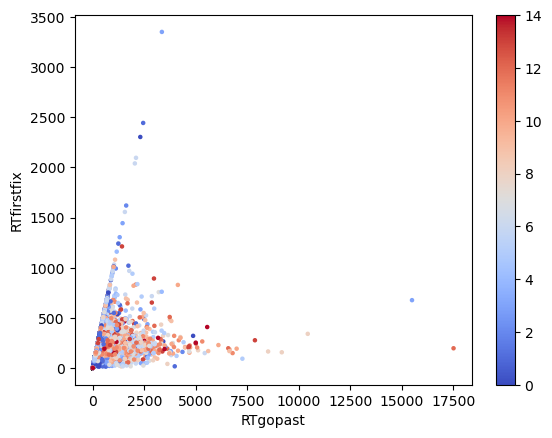

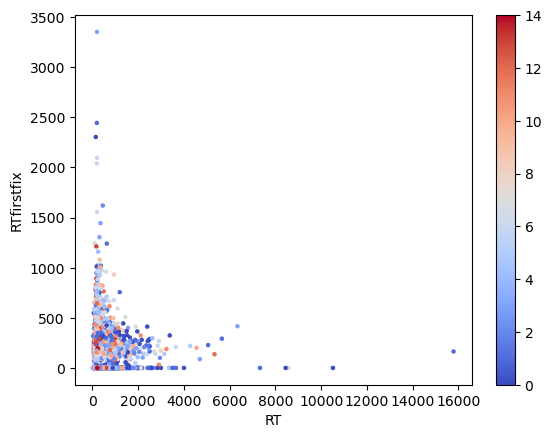

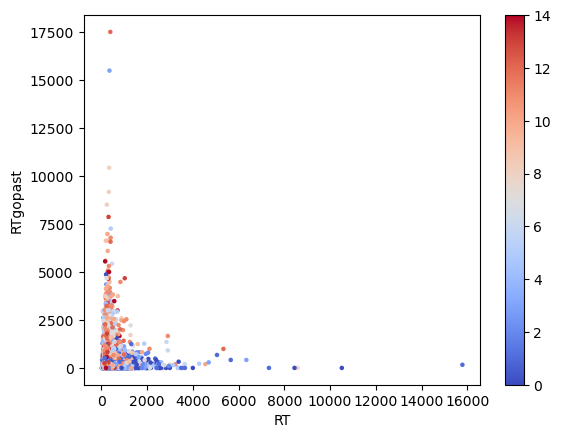

In [138]:
# We check how SPRT, FFD and GPT behave
# The colorbar refers to the position of a token in its sentence.

scatterplot(frank_both, "RTgopast", "RTfirstfix")
scatterplot(frank_both, "RT", "RTfirstfix")
scatterplot(frank_both, "RT", "RTgopast")

In [139]:
# Apparently, the further away a token is from the sentence beginning, the shorter its SPRT.
# For RT and GPT this is not so clear.

<Axes: xlabel='word_pos'>

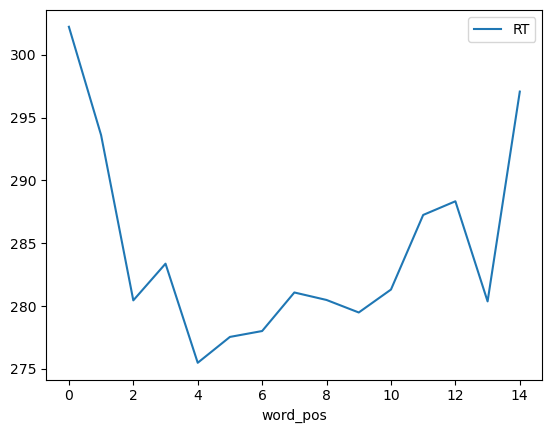

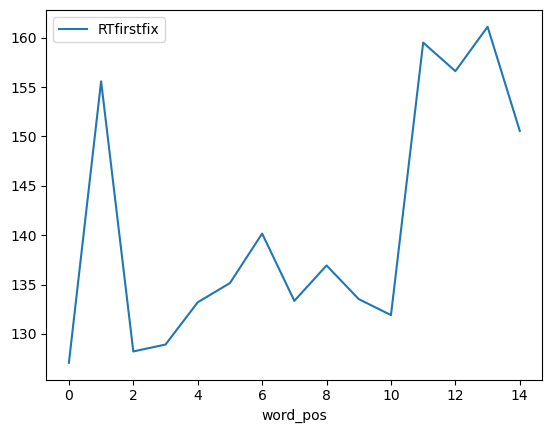

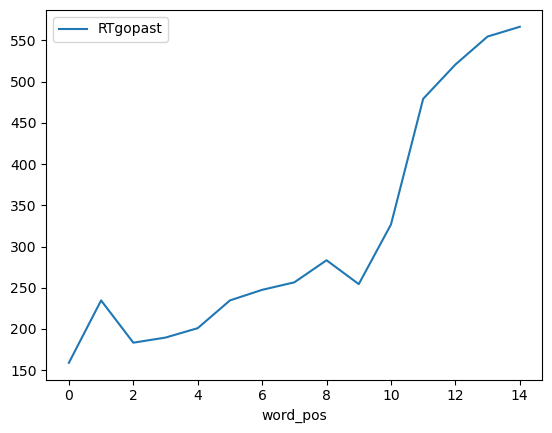

In [140]:
# Plot word position against RT metrics to see what relationship holds for FFD and GPT:

frank_both_grouped.groupby(["word_pos"]).mean(numeric_only=True).reset_index().plot(x="word_pos", y="RT")
frank_both_grouped.groupby(["word_pos"]).mean(numeric_only=True).reset_index().plot(x="word_pos", y="RTfirstfix")
frank_both_grouped.groupby(["word_pos"]).mean(numeric_only=True).reset_index().plot(x="word_pos", y="RTgopast")

In [141]:
# It seems like for FFD and GPT the opposite tendency holds: The further the
# sentence advances, the higher the metric.

<Axes: xlabel='word_pos'>

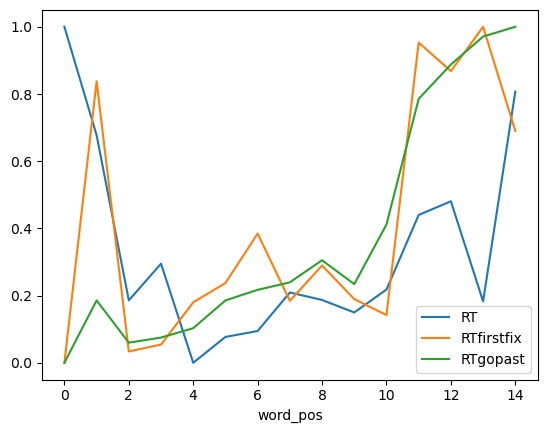

In [142]:
def minmaxnormalise(df: pd.DataFrame) -> pd.DataFrame:
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

bins = np.arange(0, 11)/10

frank_both_grouped = frank_both_grouped.merge(frank_both_grouped.groupby('sent_nr')['word_pos'].max().reset_index().rename(columns={'word_pos': 'max_pos'}), on='sent_nr')

minmaxnormalise(frank_both_grouped.groupby(["word_pos"])[["RT", "RTfirstfix", "RTgopast"]].mean()).plot()

<Axes: xlabel='word_pos'>

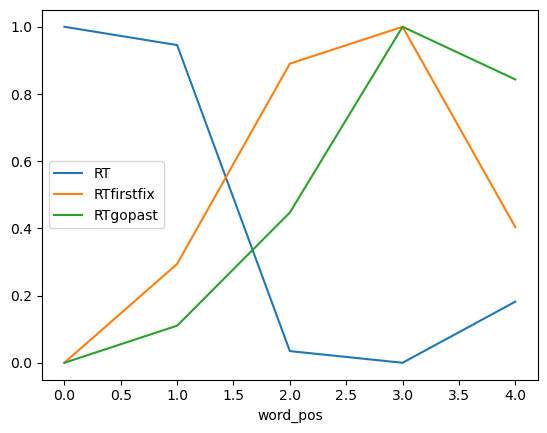

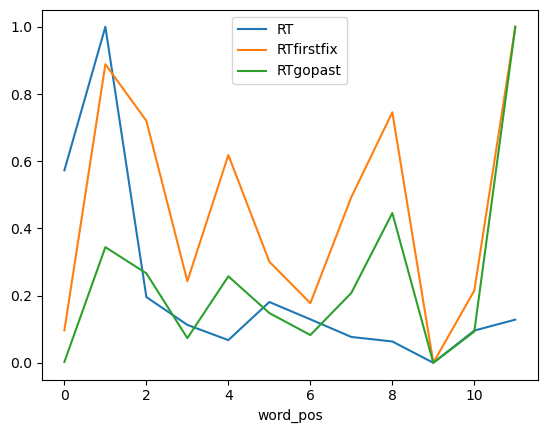

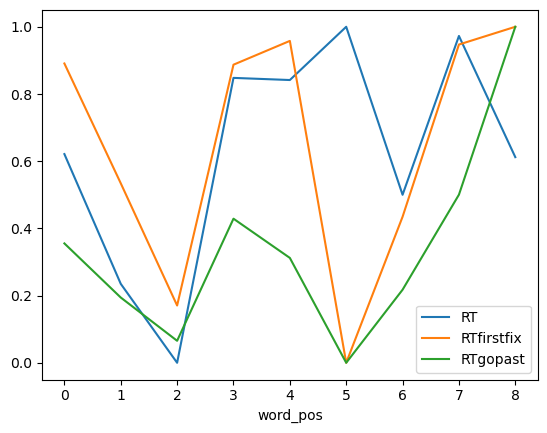

In [143]:
# Let's look at specific sentences

minmaxnormalise(frank_both_grouped[frank_both_grouped["sent_nr"] == 11][["RT", "RTfirstfix", "RTgopast", "word_pos"]].groupby("word_pos").mean(numeric_only=True)).plot()
minmaxnormalise(frank_both_grouped[frank_both_grouped["sent_nr"] == 150][["RT", "RTfirstfix", "RTgopast", "word_pos"]].groupby("word_pos").mean(numeric_only=True)).plot()
minmaxnormalise(frank_both_grouped[frank_both_grouped["sent_nr"] == 99][["RT", "RTfirstfix", "RTgopast", "word_pos"]].groupby("word_pos").mean(numeric_only=True)).plot()

<Axes: xlabel='word_pos'>

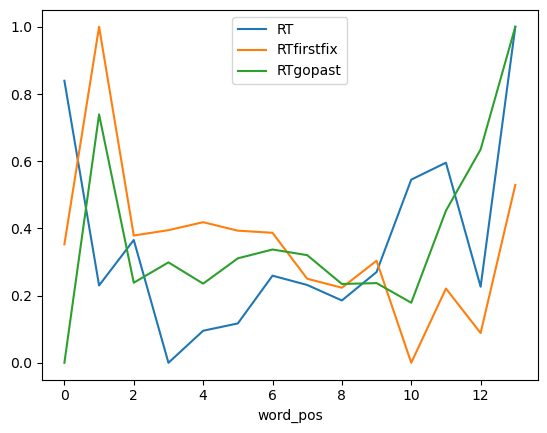

In [144]:
# Sooo... we seem to have a delay of 1 at RT. Let's shift RT by -1 steps
# and redraw the plots

grouped_by_sent = frank_both_grouped.groupby("sent_nr")
temp = frank_both_grouped.copy()
temp["sent_nr2"] = temp["sent_nr"]
shifted = temp.groupby("sent_nr2").shift(-1).dropna(subset=["sent_nr"])  #.groupby("sent_nr").apply(lambda group: group.iloc[1:]).droplevel(0)

def get_masker(to_remove):
    def make_mask(x):
        result = np.ones_like(x)
        result[to_remove] = 0
        return result
    return make_mask

mask = frank_both_grouped.groupby("sent_nr")["sent_nr"].transform(get_masker(-1)).astype(bool)
dropped = frank_both_grouped.loc[mask].copy()

dropped["RT"] = shifted["RT"]

minmaxnormalise(dropped.groupby(["word_pos"])[["RT", "RTfirstfix", "RTgopast"]].mean()).plot()


<Axes: xlabel='word_pos'>

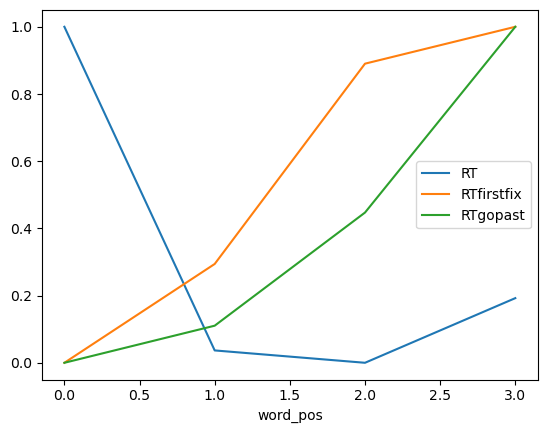

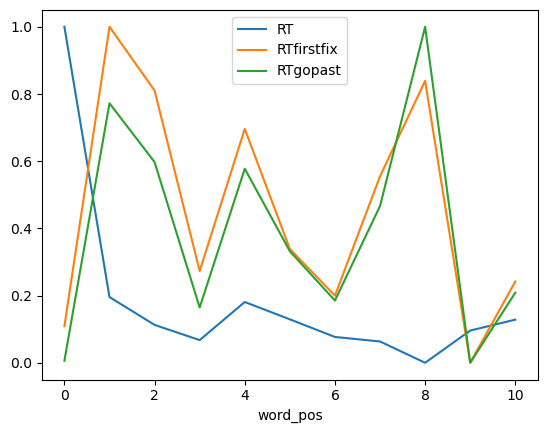

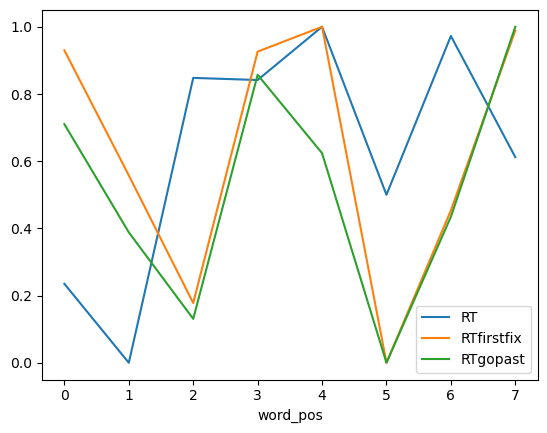

In [145]:
minmaxnormalise(dropped[dropped["sent_nr"] == 11][["RT", "RTfirstfix", "RTgopast", "word_pos"]].groupby("word_pos").mean(numeric_only=True)).plot()
minmaxnormalise(dropped[dropped["sent_nr"] == 150][["RT", "RTfirstfix", "RTgopast", "word_pos"]].groupby("word_pos").mean(numeric_only=True)).plot()
minmaxnormalise(dropped[dropped["sent_nr"] == 99][["RT", "RTfirstfix", "RTgopast", "word_pos"]].groupby("word_pos").mean(numeric_only=True)).plot()

In [146]:
# Let's compute correlations:

frank_both_grouped[["RT", "RTfirstfix", "RTgopast"]].corr()

,RT,RTfirstfix,RTgopast
RT,1.000000,0.107537,0.125126
RTfirstfix,0.107537,1.000000,0.712208
RTgopast,0.125126,0.712208,1.000000


In [147]:
dropped[["RT", "RTfirstfix", "RTgopast"]].corr()

,RT,RTfirstfix,RTgopast
RT,1.000000,0.072654,0.094248
RTfirstfix,0.072654,1.000000,0.853528
RTgopast,0.094248,0.853528,1.000000


In [148]:
# Apparently, shifting made correlations worse.

In [149]:
# Cut off one token from the start
mask = dropped.groupby("sent_nr")["sent_nr"].transform(get_masker(0)).astype(bool)
dropped.loc[mask].copy()[["RT", "RTfirstfix", "RTgopast"]].corr()

,RT,RTfirstfix,RTgopast
RT,1.000000,0.091298,0.127721
RTfirstfix,0.091298,1.000000,0.851053
RTgopast,0.127721,0.851053,1.000000


In [150]:
# Cut off one token from the start and end of unshifted dataframe
mask = frank_both_grouped.groupby("sent_nr")["sent_nr"].transform(get_masker([0, -1])).astype(bool)
frank_both_grouped.loc[mask].copy()[["RT", "RTfirstfix", "RTgopast"]].corr()

,RT,RTfirstfix,RTgopast
RT,1.000000,0.102046,0.111297
RTfirstfix,0.102046,1.000000,0.851053
RTgopast,0.111297,0.851053,1.000000


In [151]:
# Well... that did not improve things...
# What about the other measures

In [152]:
frank_both_grouped[["RT", "RTfirstfix", "RTgopast", "RTfirstpass", "RTrightbound"]].corr()

,RT,RTfirstfix,RTgopast,RTfirstpass,RTrightbound
RT,1.000000,0.107537,0.125126,0.134604,0.141357
RTfirstfix,0.107537,1.000000,0.712208,0.951537,0.922556
RTgopast,0.125126,0.712208,1.000000,0.750175,0.838580
RTfirstpass,0.134604,0.951537,0.750175,1.000000,0.968891
RTrightbound,0.141357,0.922556,0.838580,0.968891,1.000000


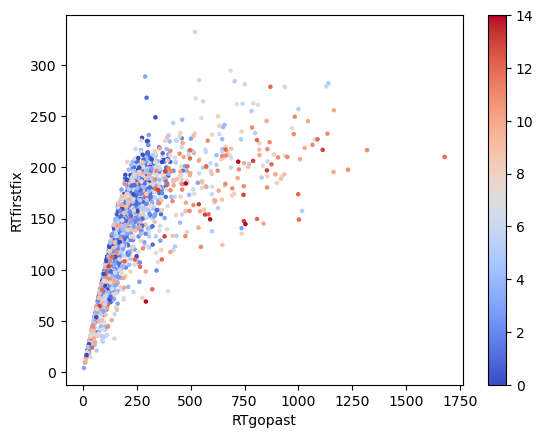

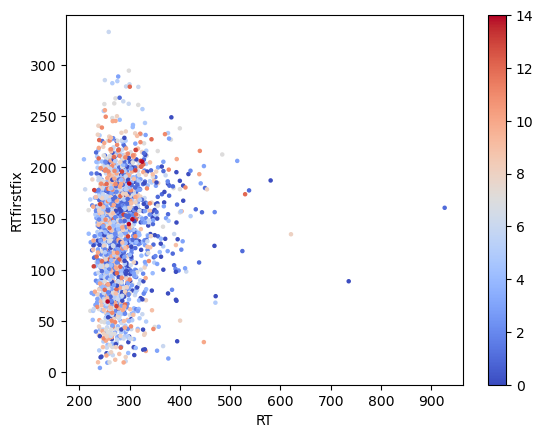

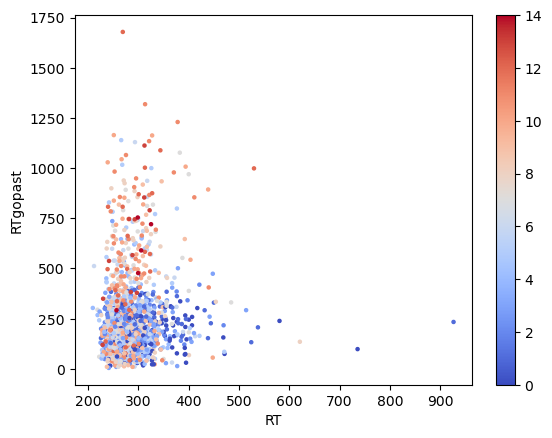

In [153]:
scatterplot(frank_both_grouped, "RTgopast", "RTfirstfix")
scatterplot(frank_both_grouped, "RT", "RTfirstfix")
scatterplot(frank_both_grouped, "RT", "RTgopast")

In [154]:
# There seem to be some systematic outliers. Are these the sentence ends?
# We need to plot them in the same colour to see this. 

In [155]:
# Therefore, we define a separate colour range for each sentence, painting
# the beginning of each sentence blue and the last item red.

from matplotlib import ticker

def scatterplot_2(
        df: pd.DataFrame, x: str, y: str, color_col: str = "word_pos", sent_col: str = "sent_nr", s: int = 5,
        *args, **kwargs) -> None:
    df = df.dropna(axis="index", subset=[x, y])
    fig, ax = plt.subplots()
    plot_colorbar = True
    for sent in df[sent_col].unique():
        sent_df = df[df[sent_col].eq(sent)].copy()
        max_pos = sent_df[color_col].max()
        sent_df["word_pos_perc"] = sent_df[color_col] / max_pos
        sent_df.plot(
            ax=ax, kind="scatter", x=x, y=y,
            c=sent_df["word_pos_perc"], cmap=cm.coolwarm, s=s, colorbar=plot_colorbar, *args, **kwargs)
        plot_colorbar = False
    cax = fig.get_axes()[1]
    labels = cax.get_yticklabels()
    step = 1/(len(labels)-1)
    cax.set_yticks(cax.get_yticks())
    cax.set_yticklabels(list(np.arange(0, 1+step, step)))



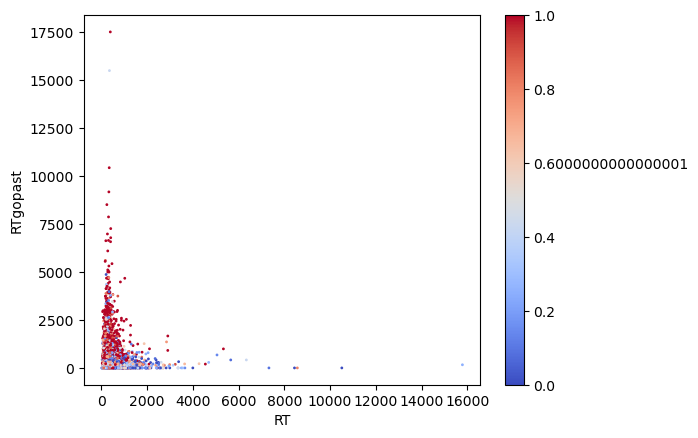

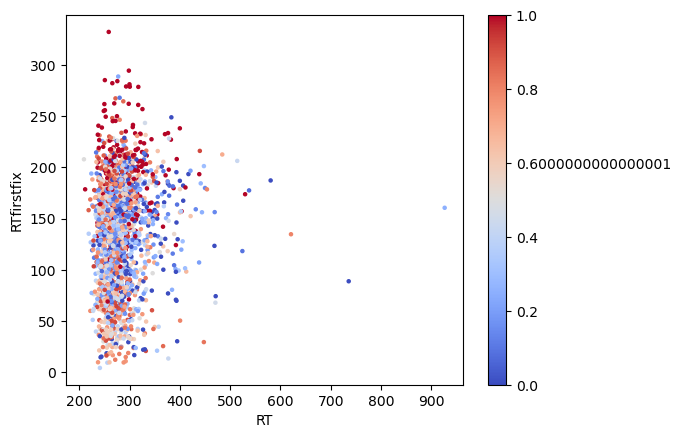

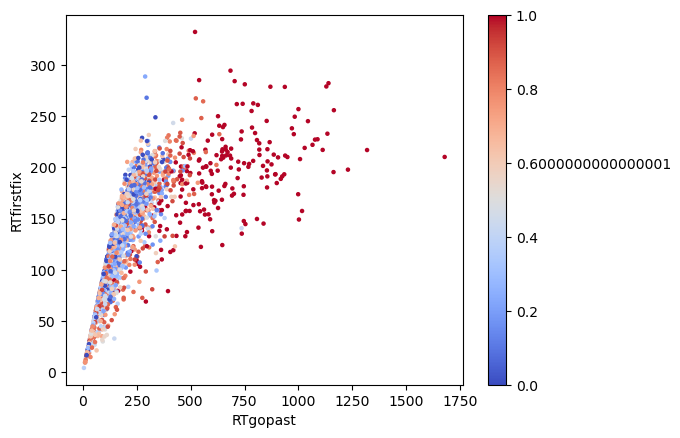

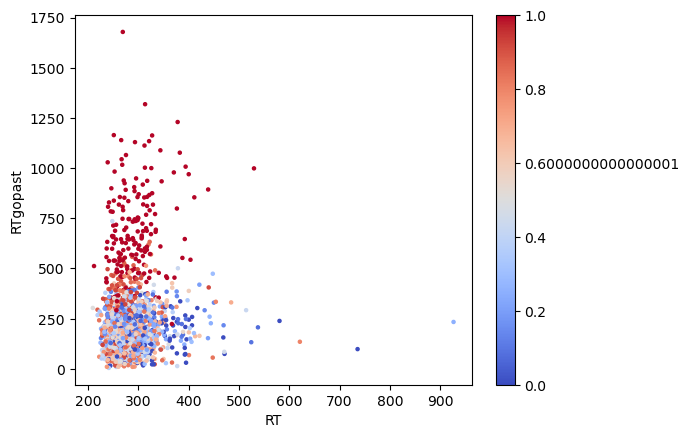

In [156]:
scatterplot_2(frank_both, "RT", "RTgopast", s=1)
scatterplot_2(frank_both_grouped, "RT", "RTfirstfix")
scatterplot_2(frank_both_grouped, "RTgopast", "RTfirstfix")
scatterplot_2(frank_both_grouped, "RT", "RTgopast")

/tmp/ipykernel_6786/1365349166.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby("binned_perc").mean(numeric_only=True).reset_index()


<Axes: xlabel='binned_perc'>

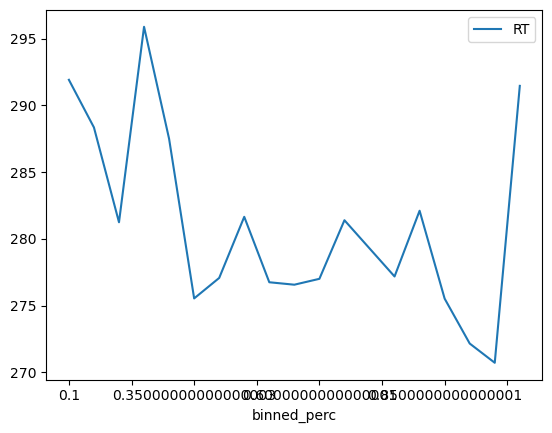

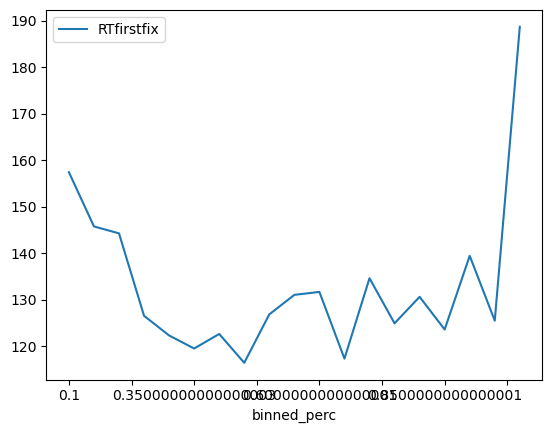

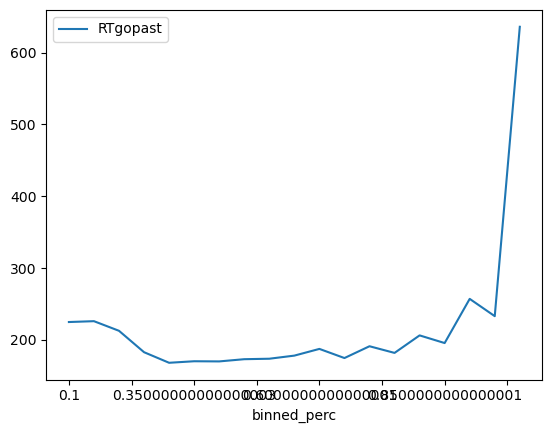

In [157]:
# Indeed, the last item in a sentence appears to exhibit a larger GPT than expected.

# Now we repeat the plot that shows position against RT metrics with position relative
# to overall sentence length

temp = frank_both_grouped.copy()
temp["word_pos_perc"] = temp["word_pos"] / temp["max_pos"]

# We make bins
step_size = 0.05
bins = np.arange(0, 1+step_size, step_size)
temp["binned_perc"] = pd.cut(temp['word_pos_perc'], bins, labels=bins[1:])
temp = temp.groupby("binned_perc").mean(numeric_only=True).reset_index()

temp.dropna(subset=["RT"]).plot(x="binned_perc", y="RT")
temp.dropna(subset=["RTfirstfix"]).plot(x="binned_perc", y="RTfirstfix")
temp.dropna(subset=["RTgopast"]).plot(x="binned_perc", y="RTgopast")

In [158]:
# All three metrics experience a rise towards the end. For GPT this rise is around 6 times higher than the signal
# in other regions of the sentence. While in RT it is approximately as high as the signal in the beginning.
# This is probably the case because in ET the reader have access to the previous stimulus while in SP they do no

# So ideally we want to cut off the end because it corrodes our observational measures.

<Axes: xlabel='binned_perc'>

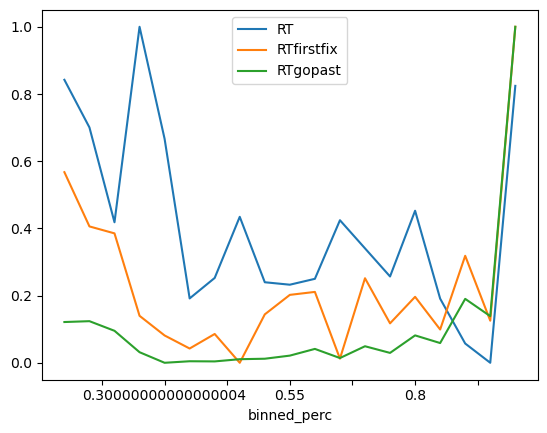

In [159]:
def minmaxnormalise(df: pd.DataFrame, ignore: set[str] = set()) -> pd.DataFrame:
    result = df.copy()
    for feature_name in df.columns:
        if not feature_name in ignore:
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

minmaxnormalise(temp, ignore={"binned_perc"})[["binned_perc", "RT", "RTfirstfix", "RTgopast"]].plot(x="binned_perc")

In [160]:
# Now let's load data that dropped the very last and the first token in each sentence.
# Let's load only sentence of the length that occurs in both subsets (ET data has a lower limit) to not
# dilute a part of our evaluation

frank_SP2 = load_csv("../../RT/data/frank_SP_preprocessed_exp1_current_1.00_0.csv").dropna(subset=["WorkerId", "item", "zone"])
frank_ET2 = load_csv("../../RT/data/frank_ET_preprocessed_exp1_current_1.00_0.csv").dropna(subset=["WorkerId", "item", "zone"])
frank_both2 = frank_ET2.merge(frank_SP2, how="inner", on=[
    "item", "zone", "WorkerId", "word", "length", "surprisal", "position", "expected_distance", "kl_divergence", "head_distance",
    "demberg","first_dependent_distance", "first_dependent_correct", "first_dependent_distance_weight", "left_dependents_distance_sum",
    "left_dependents_count", "deprel", "pos", "first_dependent_deprel", "frequency", "surprisal.s", "frequency.s", "length.s", "demberg.1", "demberg.2", "surprisal.1", "surprisal.2"])

# Reduce zone by one so it starts from 1
frank_both2["zone"] -= 2

sent_max = frank_both2.groupby("item")["zone"].max().reset_index()
sent_max = sent_max.rename(columns={"zone": "zone_max"})

frank_both2 = frank_both2.merge(
    sent_max, on=["item"], how="inner")

frank_both2 = frank_both2[frank_both2["zone_max"] < frank_both2[~frank_both2["FFD"].isna()]["zone_max"].max()+1]
frank_both_grouped2 = make_grouped(frank_both2, sent_col="item", word_col="zone")

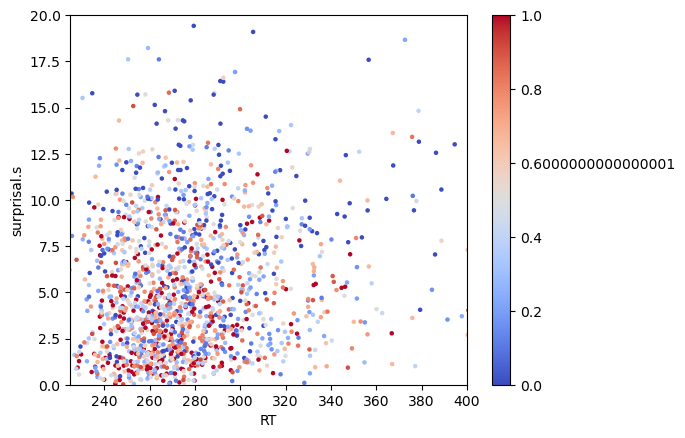

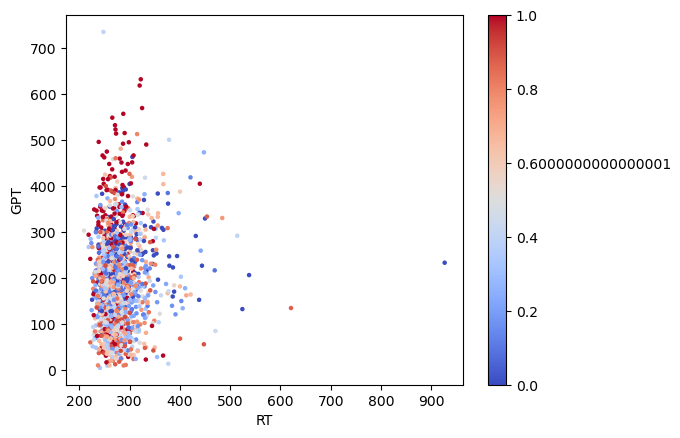

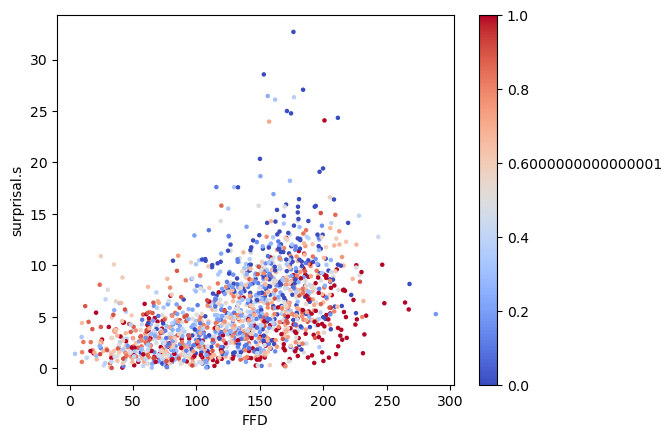

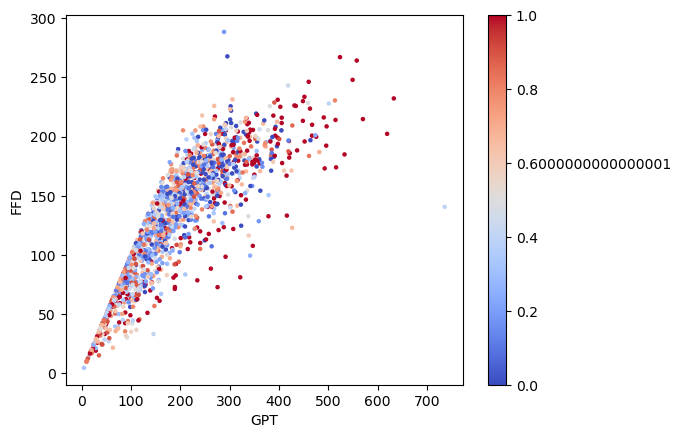

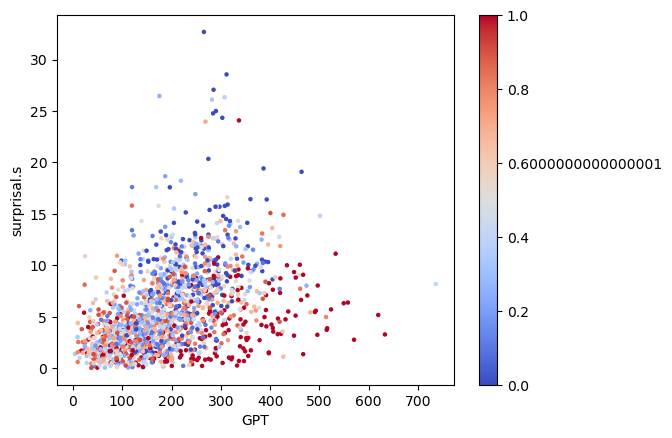

In [161]:
# Look at the plots given the data without first and last tokens

scatterplot_2(frank_both_grouped2, "RT", "surprisal.s", sent_col="item", color_col="zone", xlim=(225, 400), ylim=(0, 20))
scatterplot_2(frank_both_grouped2, "RT", "GPT", sent_col="item", color_col="zone")
scatterplot_2(frank_both_grouped2, "FFD", "surprisal.s", sent_col="item", color_col="zone")
scatterplot_2(frank_both_grouped2, "GPT", "FFD", sent_col="item", color_col="zone")
scatterplot_2(frank_both_grouped2, "GPT", "surprisal.s", sent_col="item", color_col="zone")

# TODO: Why is part of the colorbar white?

(0.0, 15.0)

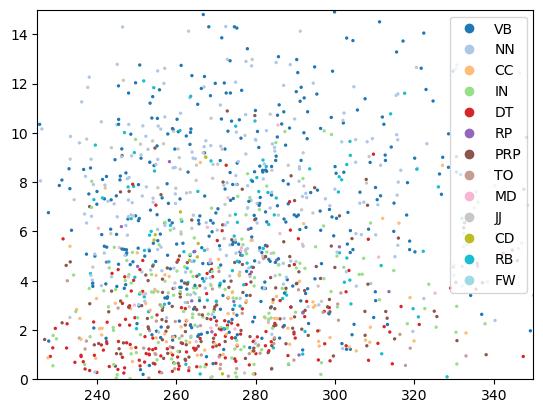

In [162]:
frank_both_grouped2["pos"] = frank_both2.groupby(["item", "zone"]).first().reset_index()["pos"]
pos_tags = frank_both_grouped2["pos"].unique()
pos2id = {pos: i for i, pos in enumerate(pos_tags)}
ids = [pos2id[pos] for pos in frank_both_grouped2["pos"]]

fig, ax = plt.subplots()
scatter = ax.scatter(frank_both_grouped2["RT"], frank_both_grouped2["surprisal.s"], s=2, c=ids, cmap=cm.tab20)
elements = scatter.legend_elements()[0]
legend = ax.legend(elements, pos_tags)
ax.set_xlim(225, 350)
ax.set_ylim(0,15)

(0.0, 15.0)

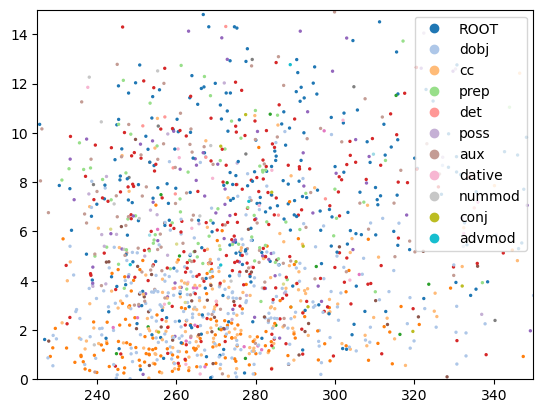

In [163]:
frank_both_grouped2["deprel"] = frank_both2.groupby(["item", "zone"]).first().reset_index()["deprel"]
pos_tags = frank_both_grouped2["deprel"].unique()
pos2id = {pos: i for i, pos in enumerate(pos_tags)}
ids = [pos2id[pos] for pos in frank_both_grouped2["deprel"]]

fig, ax = plt.subplots()
scatter = ax.scatter(frank_both_grouped2["RT"], frank_both_grouped2["surprisal.s"], s=2, c=ids, cmap=cm.tab20)
elements = scatter.legend_elements()[0]
legend = ax.legend(elements, pos_tags)
ax.set_xlim(225, 350)
ax.set_ylim(0,15)

In [164]:
# Rename columns so that they are easier to understand

frank_both2 = frank_both2.rename(columns={
    "surprisal": "surprisal",
    "surprisal.1": "surprisal+1",
    "surprisal.2": "surprisal-1",
    "demberg": "demberg",
    "demberg.1": "demberg+1",
    "demberg.2": "demberg-1",
})

In [165]:
# Check Pearson correlation coefficients between metrics and candidates

def get_proportional(frank_both2: pd.DataFrame) -> pd.DataFrame:
    frank_both_proportional2 = frank_both2.copy()
    frank_both_proportional2 = frank_both_proportional2.rename(columns={
        "surprisal": "surprisal",
        "surprisal.1": "surprisal+1",
        "surprisal.2": "surprisal-1",
        "demberg": "demberg",
        "demberg.1": "demberg+1",
        "demberg.2": "demberg-1"
    })
    sent_max2 = frank_both_proportional2.groupby("item")["zone"].max().reset_index()
    sent_max2 = sent_max2.rename(columns={"zone": "zone_max2"})
    frank_both_proportional2 = frank_both_proportional2.merge(
        sent_max2, on=["item"], how="outer")
    frank_both_proportional2["percent_of_sent"] = frank_both_proportional2["zone"] / frank_both_proportional2["zone_max2"]
    return frank_both_proportional2

frank_both_proportional2 = get_proportional(frank_both2)
frank_both_proportional2[["RT", "FFD", "GPT", "surprisal", "demberg", "frequency", "length", "position", "percent_of_sent"]].corr()

,RT,FFD,GPT,surprisal,demberg,frequency,length,position,percent_of_sent
RT,1.000000,0.026828,0.027020,0.024608,0.008971,-0.020335,0.024481,-0.019988,-0.024389
FFD,0.026828,1.000000,0.596349,0.208191,0.158922,-0.281919,0.295775,-0.064082,-0.028085
GPT,0.027020,0.596349,1.000000,0.159644,0.109445,-0.201492,0.219385,-0.023200,0.019685
surprisal,0.024608,0.208191,0.159644,1.000000,0.381603,-0.686664,0.552812,-0.260065,-0.264379
demberg,0.008971,0.158922,0.109445,0.381603,1.000000,-0.549230,0.379986,-0.028649,-0.059301
frequency,-0.020335,-0.281919,-0.201492,-0.686664,-0.549230,1.000000,-0.725213,0.193729,0.202874
length,0.024481,0.295775,0.219385,0.552812,0.379986,-0.725213,1.000000,-0.179291,-0.153180
position,-0.019988,-0.064082,-0.023200,-0.260065,-0.028649,0.193729,-0.179291,1.000000,0.840751
percent_of_sent,-0.024389,-0.028085,0.019685,-0.264379,-0.059301,0.202874,-0.153180,0.840751,1.000000


In [166]:
# Check PCC after taking token-wise mean
# Also print spillover and prediction correlation

In [167]:
def print_table(df: pd.DataFrame, sep: str = ' & ', linesep: str = ' \\ ', round_to: None | int = 2) -> str:
    output = ""
    for line_num in range(len(df)):
        output += sep.join([df.iloc[line_num].name] + [str(value if round_to is None else round(value, round_to)) for value in df.iloc[line_num]])
        output += linesep
    return output

In [199]:
to_correlate = ["RT", "FFD", "GPT", "surprisal", "surprisal+1", "demberg", "demberg+1", "demberg-1", "frequency", "length", "position", "percent_of_sent",]
frank_both_proportional_grouped2 = make_grouped(frank_both_proportional2, sent_col="item", word_col="position") 
table = frank_both_proportional_grouped2[to_correlate].corr(method="pearson")
table

,RT,FFD,GPT,surprisal,surprisal+1,demberg,demberg+1,demberg-1,frequency,length,position,percent_of_sent
RT,1.000000,0.102046,0.111297,0.116429,0.094583,0.044847,-0.006438,-0.041620,-0.098402,0.116619,-0.097474,-0.117363
FFD,0.102046,1.000000,0.851053,0.484800,-0.114977,0.374324,-0.241423,-0.124676,-0.656179,0.689549,-0.150916,-0.066884
GPT,0.111297,0.851053,1.000000,0.424177,-0.085851,0.292157,-0.191738,-0.091638,-0.535029,0.584190,-0.064658,0.051133
surprisal,0.116429,0.484800,0.424177,1.000000,0.087150,0.384218,-0.101603,-0.080324,-0.688937,0.554652,-0.260775,-0.265278
surprisal+1,0.094583,-0.114977,-0.085851,0.087150,1.000000,-0.057079,0.368601,-0.060158,0.098486,-0.082378,-0.212998,-0.188389
demberg,0.044847,0.374324,0.292157,0.384218,-0.057079,1.000000,-0.168178,-0.195245,-0.551532,0.383137,-0.028502,-0.060187
demberg+1,-0.006438,-0.241423,-0.191738,-0.101603,0.368601,-0.168178,1.000000,-0.042217,0.196432,-0.145468,0.087762,0.087160
demberg-1,-0.041620,-0.124676,-0.091638,-0.080324,-0.060158,-0.195245,-0.042217,1.000000,0.224356,-0.106620,0.074418,0.087198
frequency,-0.098402,-0.656179,-0.535029,-0.688937,0.098486,-0.551532,0.196432,0.224356,1.000000,-0.723803,0.196617,0.206268
length,0.116619,0.689549,0.584190,0.554652,-0.082378,0.383137,-0.145468,-0.106620,-0.723803,1.000000,-0.180094,-0.154243


In [198]:
print_table(table)

'RT & 1.0 & 0.1 & 0.11 & 0.12 & 0.09 & 0.04 & -0.01 & -0.04 \\ FFD & 0.1 & 1.0 & 0.85 & 0.48 & -0.11 & 0.37 & -0.24 & -0.12 \\ GPT & 0.11 & 0.85 & 1.0 & 0.42 & -0.09 & 0.29 & -0.19 & -0.09 \\ surprisal & 0.12 & 0.48 & 0.42 & 1.0 & 0.09 & 0.38 & -0.1 & -0.08 \\ surprisal+1 & 0.09 & -0.11 & -0.09 & 0.09 & 1.0 & -0.06 & 0.37 & -0.06 \\ demberg & 0.04 & 0.37 & 0.29 & 0.38 & -0.06 & 1.0 & -0.17 & -0.2 \\ demberg+1 & -0.01 & -0.24 & -0.19 & -0.1 & 0.37 & -0.17 & 1.0 & -0.04 \\ demberg-1 & -0.04 & -0.12 & -0.09 & -0.08 & -0.06 & -0.2 & -0.04 & 1.0 \\ '

In [172]:
# We can see a lot:
# 

In [200]:
frank_both_proportional_grouped2[to_correlate].corr(method="spearman")

# We have a higher correlation for RT and surprisal+1 than with Pearson. Maybe the correlation is not linear?

,RT,FFD,GPT,surprisal,surprisal+1,demberg,demberg+1,demberg-1,frequency,length,position,percent_of_sent
RT,1.000000,0.121206,0.114439,0.129386,0.146870,0.066888,0.037242,-0.055242,-0.114988,0.122115,-0.104245,-0.109849
FFD,0.121206,1.000000,0.893976,0.546008,-0.123267,0.436371,-0.229267,-0.158361,-0.674552,0.749093,-0.140733,-0.049446
GPT,0.114439,0.893976,1.000000,0.501391,-0.101647,0.379442,-0.224366,-0.119349,-0.593670,0.674672,-0.125557,-0.005875
surprisal,0.129386,0.546008,0.501391,1.000000,-0.002955,0.495416,-0.095355,-0.213643,-0.759445,0.613547,-0.256269,-0.250074
surprisal+1,0.146870,-0.123267,-0.101647,-0.002955,1.000000,-0.137834,0.479169,-0.045658,0.121616,-0.099868,-0.229979,-0.189217
demberg,0.066888,0.436371,0.379442,0.495416,-0.137834,1.000000,-0.211933,-0.264832,-0.650645,0.485604,-0.146891,-0.167546
demberg+1,0.037242,-0.229267,-0.224366,-0.095355,0.479169,-0.211933,1.000000,-0.058094,0.189341,-0.157448,-0.018222,0.001681
demberg-1,-0.055242,-0.158361,-0.119349,-0.213643,-0.045658,-0.264832,-0.058094,1.000000,0.307429,-0.173841,0.045043,0.075301
frequency,-0.114988,-0.674552,-0.593670,-0.759445,0.121616,-0.650645,0.189341,0.307429,1.000000,-0.756428,0.195342,0.206154
length,0.122115,0.749093,0.674672,0.613547,-0.099868,0.485604,-0.157448,-0.173841,-0.756428,1.000000,-0.185058,-0.171972


/tmp/ipykernel_6786/3638643051.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby("binned_perc").mean(numeric_only=True).reset_index()


<Axes: xlabel='binned_perc'>

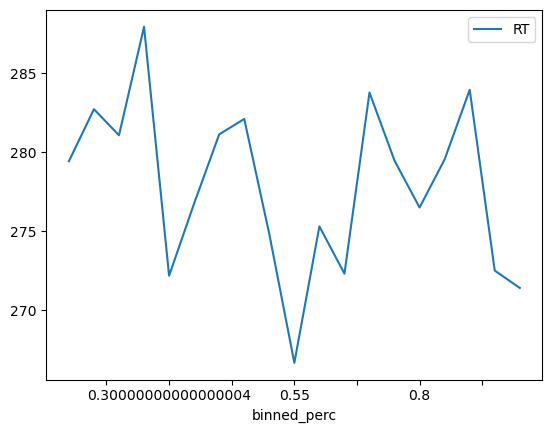

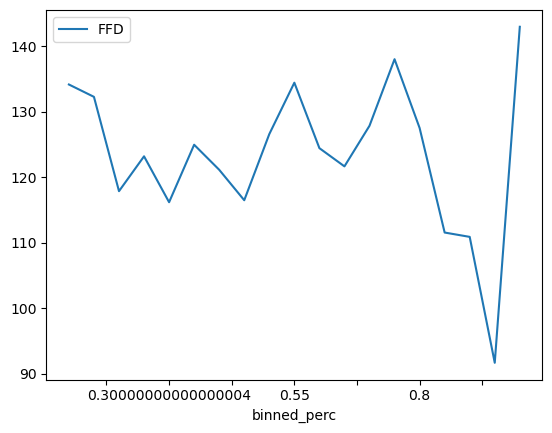

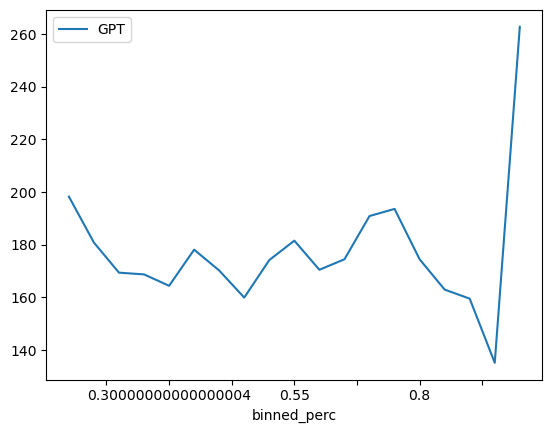

In [174]:
# Now we repeat the plot that shows position against RT metrics with position relative
# to overall sentence length

temp = frank_both_grouped2.copy()
max_pos = temp.groupby(["item"])["zone"].max().reset_index().rename(columns={"zone": "max_zone"})
temp = temp.merge(max_pos, how="inner", on="item")
temp["zone_perc"] = temp["zone"] / temp["max_zone"]

# We make bins
step_size = 0.05
bins = np.arange(0, 1+step_size, step_size)
temp["binned_perc"] = pd.cut(temp['zone_perc'], bins, labels=bins[1:])
temp = temp.groupby("binned_perc").mean(numeric_only=True).reset_index()

temp.plot(x="binned_perc", y="RT")
temp.plot(x="binned_perc", y="FFD")
temp.plot(x="binned_perc", y="GPT")

/tmp/ipykernel_6786/2357119937.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  minmaxnormalise(frank_both_proportional_grouped2.groupby(["binned"])[["surprisal", "RT", "FFD", "GPT", "-zone"]].mean()).plot()


<Axes: xlabel='binned'>

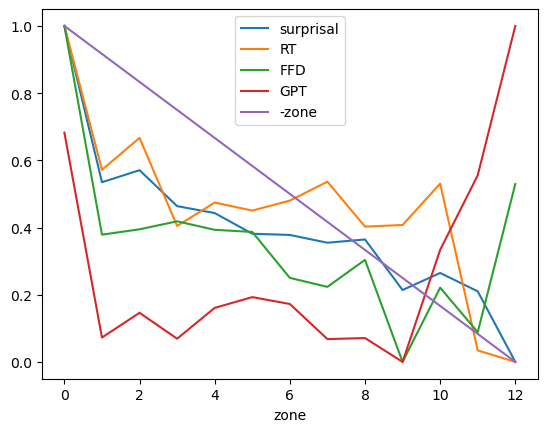

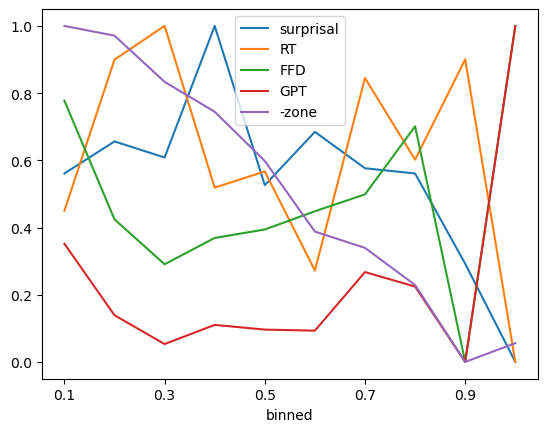

In [175]:
bins = np.arange(0, 11)/10
frank_both_proportional_grouped2['binned'] = pd.cut(frank_both_proportional_grouped2['percent_of_sent'], bins, labels=bins[1:])
frank_both_proportional_grouped2['-zone'] = -frank_both_proportional_grouped2['zone']

minmaxnormalise(frank_both_proportional_grouped2.groupby(["zone"])[["surprisal", "RT", "FFD", "GPT", "-zone"]].mean()).plot()
minmaxnormalise(frank_both_proportional_grouped2.groupby(["binned"])[["surprisal", "RT", "FFD", "GPT", "-zone"]].mean()).plot()

<Axes: xlabel='zone'>

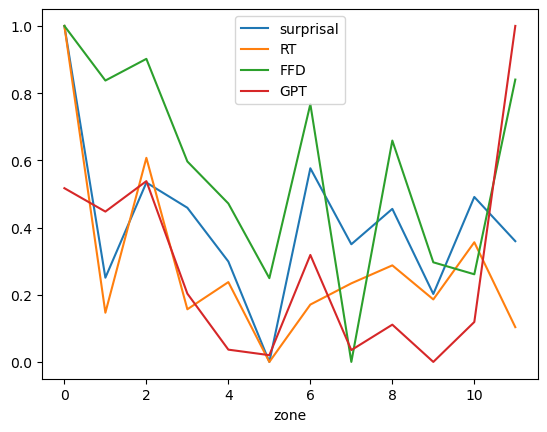

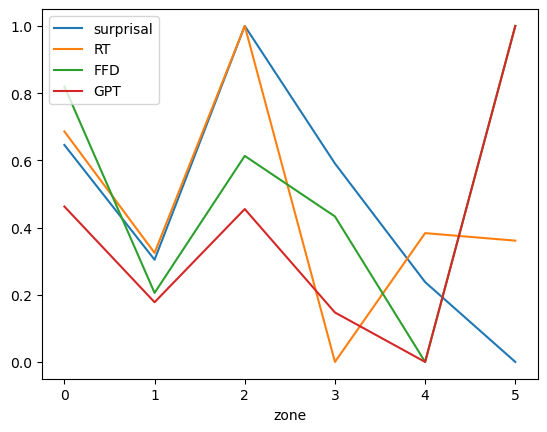

In [176]:
# Let's look at sentences of a specific length

minmaxnormalise(frank_both_proportional_grouped2[frank_both_proportional_grouped2["zone_max"] == 11][["surprisal", "RT", "FFD", "GPT", "zone"]].groupby("zone").mean(numeric_only=True)).plot()
minmaxnormalise(frank_both_proportional_grouped2[frank_both_proportional_grouped2["zone_max"] == 5][["surprisal", "RT", "FFD", "GPT", "zone"]].groupby("zone").mean(numeric_only=True)).plot()

In [177]:
# RT, FFD, GPT seem to have a similar development inside a sentence, except for the end where RT goes down and FFD and GPT goes up.
# Maybe cut off one additional last element?
# The same holds for surprisal.
# We seem to have higher spillover effects for RT (see correlation matrix) while ET metrics are closer to surprisal.

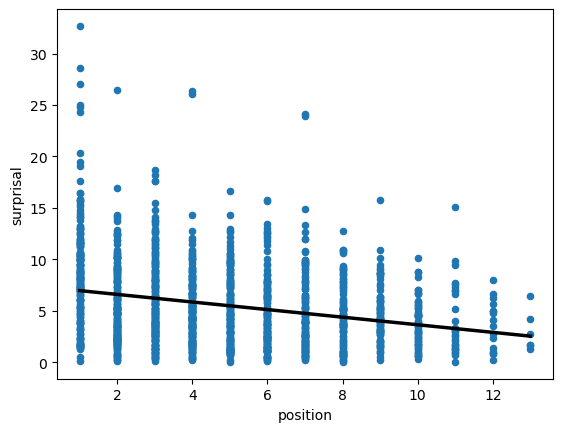

In [178]:
def regression(df: pd.DataFrame, x: str, y: str) -> None:
    fig, ax = plt.subplots()

    df.plot(ax=ax, kind="scatter", x=x, y=y)

    b, a = np.polyfit(df[x], df[y], deg=1)

    # Create sequence of 100 numbers from 0 to 100
    xseq = np.linspace(frank_both_proportional_grouped2[x].min(), frank_both_proportional_grouped2[x].max(), num=100)

    # Plot regression line
    ax.plot(xseq, a + b * xseq, color="k", lw=2.5)

regression(frank_both_proportional_grouped2, "position", "surprisal")

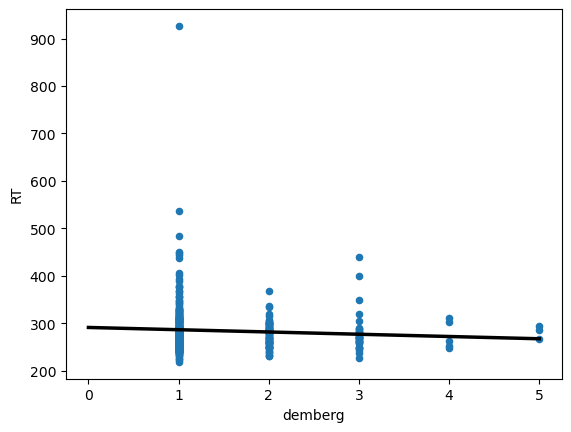

In [179]:
fvb_g = make_grouped(frank_both_proportional2[frank_both_proportional2["pos"] == "VB"], sent_col="item", word_col="position")
regression(fvb_g, "demberg", "RT")

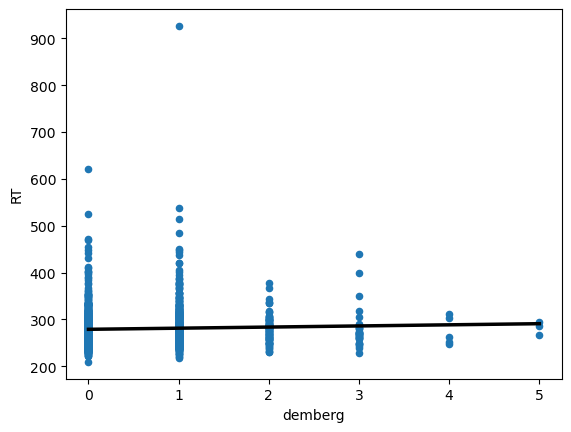

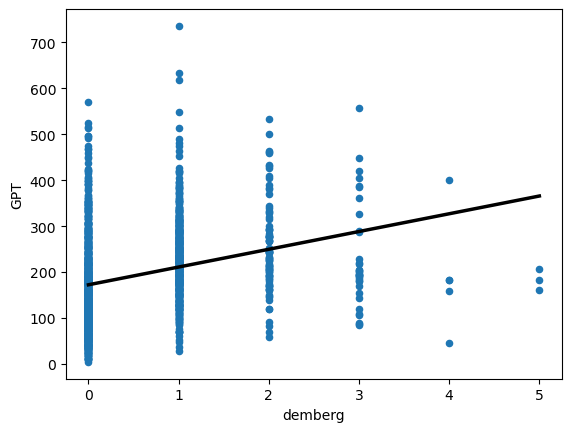

In [180]:
regression(frank_both_proportional_grouped2, "demberg", "RT")
regression(frank_both_proportional_grouped2, "demberg", "GPT")

/tmp/ipykernel_6786/2013034866.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby("binned_RT").mean(numeric_only=True).reset_index()


<Axes: xlabel='binned_RT'>

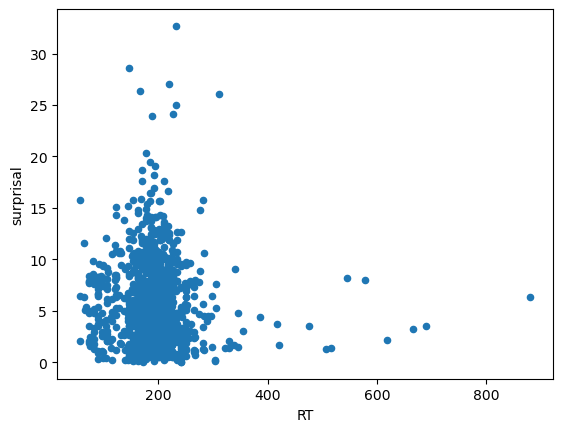

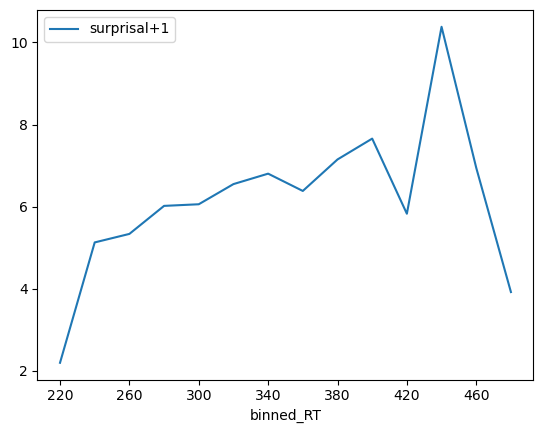

In [181]:
frank_both_proportional2[np.logical_and(frank_both_proportional2["WorkerId"] == 17, frank_both_proportional2["RT"] < 1000)].plot(kind="scatter", x="RT", y="surprisal")
bins = np.arange(0, 500, 20)
temp = frank_both_proportional_grouped2.copy()
pd.cut(frank_both_proportional_grouped2['RT'], bins, labels=bins[1:])
temp["binned_RT"] = pd.cut(frank_both_proportional_grouped2['RT'], bins, labels=bins[1:])
temp = temp.groupby("binned_RT").mean(numeric_only=True).reset_index()
temp.plot(x="binned_RT", y="surprisal+1")


<Axes: xlabel='RT', ylabel='surprisal_n'>

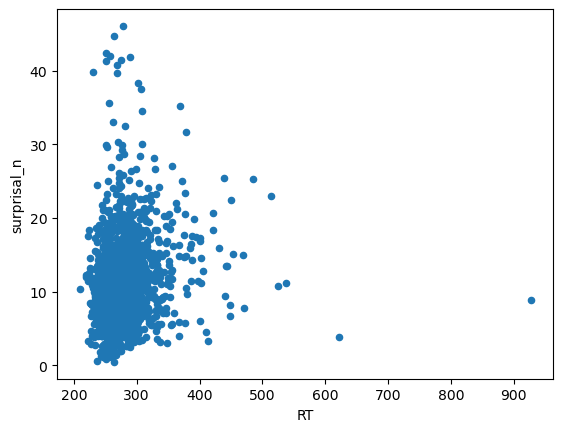

In [182]:
frank_both_proportional_grouped2["surprisal_n"] = frank_both_proportional_grouped2["surprisal"] + frank_both_proportional_grouped2["surprisal+1"]
frank_both_proportional_grouped2.plot(kind="scatter", x="RT", y="surprisal_n")

<Axes: xlabel='position'>

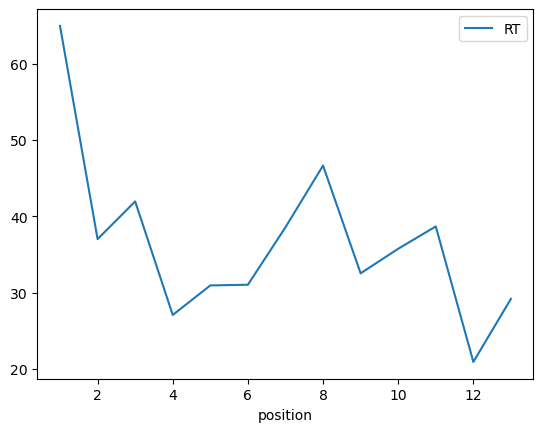

In [183]:
frank_both_proportional_grouped2.groupby(["position"]).std(numeric_only=True).reset_index().plot(x="position", y="RT")

<Axes: xlabel='GPT', ylabel='surprisal'>

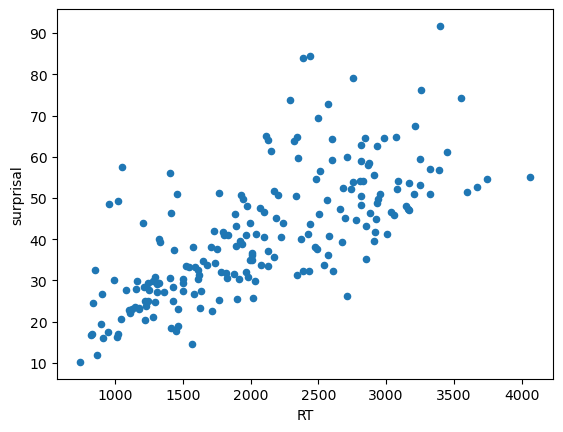

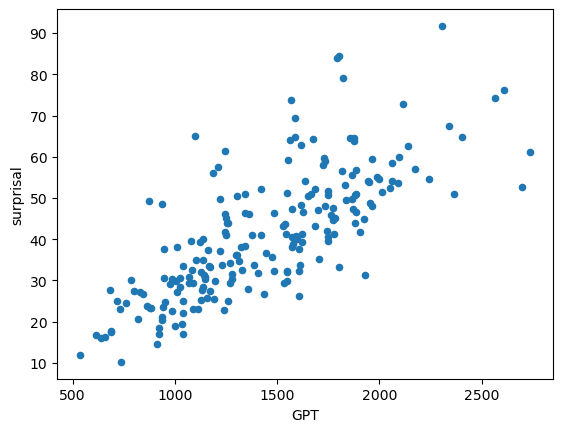

In [184]:
by_item = frank_both_proportional_grouped2.groupby(["item"]).sum(numeric_only=True)
by_item = by_item[by_item["RT"] != 0]
by_item = by_item[by_item["GPT"] != 0]
by_item.plot(kind="scatter", x="RT", y="surprisal")
by_item.plot(kind="scatter", x="GPT", y="surprisal")

/tmp/ipykernel_6786/977804368.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  minmaxnormalise(frank_both_proportional_grouped2.groupby(["binned"])[["surprisal", "RT", "FFD", "GPT", "-zone"]].mean()).plot()


<Axes: xlabel='binned'>

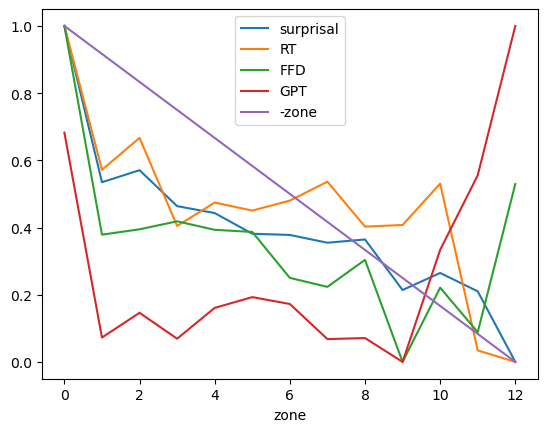

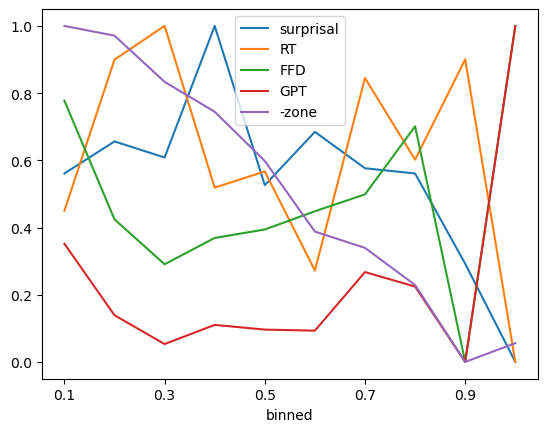

In [185]:
minmaxnormalise(frank_both_proportional_grouped2.groupby(["zone"])[["surprisal", "RT", "FFD", "GPT", "-zone"]].mean()).plot()
minmaxnormalise(frank_both_proportional_grouped2.groupby(["binned"])[["surprisal", "RT", "FFD", "GPT", "-zone"]].mean()).plot()

In [186]:
frank_both_proportional_grouped2

,item,position,zone,WorkerId,FFD,GPT,frequency,length,surprisal,head_distance,...,expected_distance.2_y,kl_divergence.2_y,surprisal.s.1_y,surprisal.s.2_y,zone_max,zone_max2,percent_of_sent,binned,-zone,surprisal_n
0,1,1,0.0,24.173913,170.434783,262.782609,5.39,4.0,8.091506,0.0,...,1.199699,6.050330,8.133706,3.779719,2.0,2.0,0.000000,NaN,-0.0,16.225212
1,1,2,1.0,24.173913,169.739130,237.913043,5.40,7.0,3.779719,-1.0,...,2.551514,5.202012,8.091506,4.872049,2.0,2.0,0.500000,0.5,-1.0,11.871225
2,1,3,2.0,24.173913,67.130435,112.000000,7.41,3.0,4.872049,0.0,...,2.176645,6.689727,3.779719,17.839870,2.0,2.0,1.000000,1.0,-2.0,8.651768
3,2,1,0.0,21.933333,173.733333,309.200000,5.04,5.0,10.056364,0.0,...,0.383198,3.464128,11.168557,5.165341,2.0,2.0,0.000000,NaN,-0.0,21.224921
4,2,2,1.0,21.933333,73.066667,88.933333,6.91,2.0,5.165341,0.0,...,1.212150,7.321413,10.056364,0.902529,2.0,2.0,0.500000,0.5,-1.0,15.221705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,246,9,8.0,24.095238,40.761905,40.761905,6.63,3.0,6.335325,0.0,...,4.527640,8.830499,0.293437,4.515840,12.0,12.0,0.666667,0.7,-8.0,6.628763
1517,246,10,9.0,24.095238,85.714286,85.714286,6.95,2.0,4.515840,0.0,...,4.414911,5.068386,6.335325,7.282670,12.0,12.0,0.750000,0.8,-9.0,10.851165
1518,246,11,10.0,24.095238,184.000000,192.761905,5.13,4.0,7.282670,-10.0,...,5.640633,7.402612,4.515840,2.748228,12.0,12.0,0.833333,0.9,-10.0,11.798510
1519,246,12,11.0,24.095238,112.952381,136.000000,6.41,4.0,2.748228,0.0,...,5.914659,8.500774,7.282670,1.275485,12.0,12.0,0.916667,1.0,-11.0,10.030898


In [187]:
frank_both_proportional_grouped2

,item,position,zone,WorkerId,FFD,GPT,frequency,length,surprisal,head_distance,...,expected_distance.2_y,kl_divergence.2_y,surprisal.s.1_y,surprisal.s.2_y,zone_max,zone_max2,percent_of_sent,binned,-zone,surprisal_n
0,1,1,0.0,24.173913,170.434783,262.782609,5.39,4.0,8.091506,0.0,...,1.199699,6.050330,8.133706,3.779719,2.0,2.0,0.000000,NaN,-0.0,16.225212
1,1,2,1.0,24.173913,169.739130,237.913043,5.40,7.0,3.779719,-1.0,...,2.551514,5.202012,8.091506,4.872049,2.0,2.0,0.500000,0.5,-1.0,11.871225
2,1,3,2.0,24.173913,67.130435,112.000000,7.41,3.0,4.872049,0.0,...,2.176645,6.689727,3.779719,17.839870,2.0,2.0,1.000000,1.0,-2.0,8.651768
3,2,1,0.0,21.933333,173.733333,309.200000,5.04,5.0,10.056364,0.0,...,0.383198,3.464128,11.168557,5.165341,2.0,2.0,0.000000,NaN,-0.0,21.224921
4,2,2,1.0,21.933333,73.066667,88.933333,6.91,2.0,5.165341,0.0,...,1.212150,7.321413,10.056364,0.902529,2.0,2.0,0.500000,0.5,-1.0,15.221705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,246,9,8.0,24.095238,40.761905,40.761905,6.63,3.0,6.335325,0.0,...,4.527640,8.830499,0.293437,4.515840,12.0,12.0,0.666667,0.7,-8.0,6.628763
1517,246,10,9.0,24.095238,85.714286,85.714286,6.95,2.0,4.515840,0.0,...,4.414911,5.068386,6.335325,7.282670,12.0,12.0,0.750000,0.8,-9.0,10.851165
1518,246,11,10.0,24.095238,184.000000,192.761905,5.13,4.0,7.282670,-10.0,...,5.640633,7.402612,4.515840,2.748228,12.0,12.0,0.833333,0.9,-10.0,11.798510
1519,246,12,11.0,24.095238,112.952381,136.000000,6.41,4.0,2.748228,0.0,...,5.914659,8.500774,7.282670,1.275485,12.0,12.0,0.916667,1.0,-11.0,10.030898


In [188]:
from sklearn import linear_model
from sklearn import preprocessing

temp = frank_both_proportional_grouped2.dropna(subset=["surprisal"])
X = temp[["surprisal"]]
y = temp[["RT"]]

lm = linear_model.LinearRegression()
reg = linear_model.LinearRegression().fit(X, y)
preds = reg.predict(X)
reg.score(X, y)

0.013555632679842833

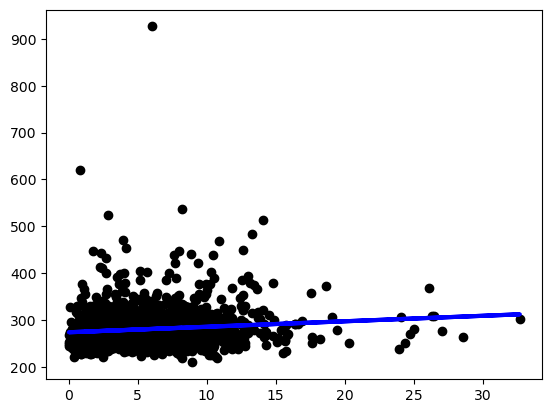

In [189]:
plt.scatter(X, y, color="black")
plt.plot(X, preds, color="blue", linewidth=3)

plt.show()

In [190]:
X = temp[["surprisal"]]

poly = preprocessing.PolynomialFeatures(2)
X = poly.fit_transform(X)

reg = linear_model.LinearRegression().fit(X, y)
reg.score(X, y)

0.014949994509757092

In [191]:
X = temp[["surprisal+1"]]

poly = preprocessing.PolynomialFeatures(2)
X = poly.fit_transform(X)

reg = linear_model.LinearRegression().fit(X, y)
reg.score(X, y)

0.012206295083992957

In [192]:
X = temp[["surprisal", "surprisal+1"]]

poly = preprocessing.PolynomialFeatures(2)
X = poly.fit_transform(X)

reg = linear_model.LinearRegression().fit(X, y)
reg.score(X, y)

0.02807239046789256

In [193]:
X = temp[["surprisal", "surprisal+1", "position", "demberg", "demberg+1", "demberg-1"]]

poly = preprocessing.PolynomialFeatures(2)
X = poly.fit_transform(X)

reg = linear_model.LinearRegression().fit(X, y)
reg.score(X, y)

0.04204152231030611

In [194]:
# Analyse the errors made by the linear regression to find out where surprisal underexplains

temp = frank_both_proportional_grouped2.dropna(subset=["surprisal"])
X = temp[["surprisal"]]
y = temp[["RT"]]

lm = linear_model.LinearRegression()
reg = linear_model.LinearRegression().fit(X, y)
error = reg.predict(X) - y

columns = temp.select_dtypes(include=[np.number]).dropna(axis="columns").columns
results = []
for column in columns:
    X2 = temp[[column]]
    lm2 = linear_model.LinearRegression()
    reg2 = linear_model.LinearRegression().fit(X2, error)
    results.append(reg2.score(X2, error))

pd.DataFrame({"column": columns, "score": [round(value, 3) for value in results]})


,column,score
0,item,0.001
1,position,0.005
2,zone,0.005
3,WorkerId,0.001
4,FFD,0.002
...,...,...
66,zone_max,0.001
67,zone_max2,0.001
68,percent_of_sent,0.008
69,-zone,0.005
